In [185]:
#TODO
#1. check the taskSequence after repair methods especially the presence of Unloaded tasks around charge tasks
#2.a Enquire what makes sense, addition of 1 NC charge and then greedily insert C tasks or, adding NC/C wherever applicable or just add 2 more functions which do both <- preferred
#2. complete repair methods by using greedy repair objects
#3. Add removal of charge tasks that lead to negative increase in charge after LP
#4. Convert all constants to UPPERCASE

In [186]:
#DEBUG FUNCTION
%set_env PYTHONBREAKPOINT=IPython.core.debugger.set_trace
def debugIt(statement):
    pass
#     print(statement)


env: PYTHONBREAKPOINT=IPython.core.debugger.set_trace


### Imports

In [187]:
import numpy as np
import pandas as pd
from pandas import read_excel
import matplotlib.pyplot as plt
from csv import reader
# import gurobipy as grb
from gurobipy import *
import random 
import copy # to deep copy from taskSequence to taskSchedule
from time import *

### Station

In [188]:
'''
Station Object
- Pickup / Delivery Nodes
- Charging Nodes
'''
class Station():
    
    def __init__(self,nodeId,name, stType, mhTime):
        self.nodeId = int(nodeId) # an integer representing the unique id of a node
        self.name = name #name of the node
        self.stType = stType #station Type (P/D/C/PD)
        self.mhTime = mhTime # material handling time associated with the station 
    
    def __repr__(self):
        return f"Station#{self.nodeId} - {self.name} - {self.stType}"
    
    def getType(self):
        '''
        Returns type of node
        '''
        return self.stType
    
    def getNode(self):
        '''
        returns integer id of the node
        '''
        return self.nodeId
    
    def getMHT(self):
        '''
        returns material handling time at the station
        '''
        return self.mhTime

### Task
This class represents the following types of tasks:
Charge Task,
Non-Critical Charge task,
MH Task,
Unloaded Travel Task

In [189]:
'''
Class representing a task
Charge Task
Non-Critical Charge task
MH Task
Unloaded Travel Task
'''
class Task():
    
    def __init__(self, taskId, taskType, source, dest):
        self.taskId=taskId #this is the original id of the request from the file
        self.taskIndex=888 #this is changed based on order of tasks, use this to locate charge tasks
        self.taskType = taskType
        self.source = source
        self.dest = dest
        
    def __repr__(self):
        return f"{self.taskId}-{self.taskType}-{self.source}-{self.dest}"

### Transport Order Task (Inherited from Task)

In [190]:
'''
This class represents an inherited object(Transport Order) of a TASK'''
class TransportOrder(Task):
    def __init__(self,taskId, taskType, source, dest, ept, ldt, cap):
        super().__init__(taskId, taskType, source, dest) #call 'Task' class constructor
        self.ept = ept
        self.ldt = ldt
        self.cap = cap
        
    def __repr__(self):
        return f"{self.taskId}-{self.taskType}-{self.source}-{self.dest}-{self.ept}-{self.ldt}-{self.cap}"

### Layout

In [191]:
class Layout():
    
    def __init__(self, fileName):
        self.distMat=[]
        self.readDistanceMatrix(fileName)
    
    def readDistanceMatrix(self,fileName):
        dm = reader(open(fileName))
        self.distMat = list(dm)
        self.distMat[0][0]=0
        
        for f,fr in enumerate(self.distMat):
            for t,to in enumerate(fr):
                self.distMat[f][t] = float(self.distMat[f][t])
                
    
    def getDistanceFromNode(self, source, dest):
        '''
        returns the distance (in m) between 2 nodes
        '''
        return float(self.distMat[source][dest])
    
    def getMaxDistance(self):
        '''
        returns the maximum distance value
        '''
        maximum_distance=0
        for i in self.distMat:
            for j in i:
                if j>maximum_distance:
                    maximum_distance=j
        return maximum_distance
                

### AGV

In [192]:
class AGV():
    def __init__(self, agvId, startNode, caps, speed, charge, dischargeRate, chargeRate, taskList, travelCost, low=30, up=60):
        
        self.agvId = agvId #agv id
        self.startNode = startNode #initial node
        self.caps = caps #capability
        self.speed = speed # speed in m/s
        self.charge = charge # charge %
        self.dischargeRate = dischargeRate # % per second
        self.chargeRate = chargeRate # % per second
        self.travelCost = travelCost # weighted travel cost
        self.LOWER_THRESHOLD = low # lower threshold of charging
        self.UPPER_THRESHOLD =up # upper threshold of charging
        self.state = 'N'
    
    def __repr__(self):
        return f"{self.agvId}-{self.speed}m/s-{self.charge}%-{self.travelCost}"
    
    def getSpeed(self):
        '''
        Returns speed of agv in m/s
        '''
        return self.speed
    
    def getChargeRate(self):
        '''
        Returns charging rate of agv in %/sec
        '''
        return self.chargeRate
    
    def getDischargeRate(self):
        '''
        Returns discharging rate of agv in %/sec
        '''
        return self.dischargeRate
    

### Scheduler Class
This class is responsible for scheduling tasks on AGVs based on system state

In [193]:

class ALNSRepair():
    
    def __init__(self):
        self.agvInfo={}
    
    def setAGVInfo(self,agv):
        self.agvInfo['agvId']=agv.agvId
        self.agvInfo['charge']=agv.charge
        self.agvInfo['startNode']=agv.startNode
        self.agvInfo['release']=(0, agv.startNode) # (time, node)
        self.agvInfo['state']=agv.state
    
    def getCurrentReleaseNode(self):
        '''
        returns agv's current release node
        '''
        return self.agvInfo['release'][1]
    
    def setCurrentReleaseNode(self, releaseNode):
        '''
        sets current release node
        '''
        self.agvInfo['release']= (self.agvInfo['release'][0], releaseNode)
    
    def getCurrentReleaseTime(self):
        '''
        returns current release time
        '''
        return self.agvInfo['release'][0]
    
    def setCurrentReleaseTime(self, releaseTime):
        '''
        set current release time
        '''
        self.agvInfo['release'] = (releaseTime,self.agvInfo['release'][1])
    
    def getState(self):
        '''
        gets state of agv
        '''
        return self.agvInfo['state']
        
    def setState(self,state):
        '''
        sets state of agv
        '''
        self.agvInfo['state']=state
        
    def setCharge(self, charge):
        '''
        Sets the agv charge
        '''
        self.agvInfo['charge'] = min(100,charge)
        
    def getCharge(self):
        '''
        Returns AGV Charge in %age
        '''
        return self.agvInfo['charge']
    
    def getStartNode(self,agv):
        '''
        Returns agv's initial/start node'''
        return self.agvInfo['startNode']
        
        
        
    def repairInsertAllCharge(self,agv,taskList,scheduler):
        '''
        method that modifies taskList by inserting a charge task after every task in a given taskList
        '''
        #TODO : maybe if the agv is in 'C' state, modify the repair to have a charge request first?
        taskList[:]=list(filter(lambda x:x.taskType=='TO',taskList)) # this way reference to original object is maintained
           
        taskCopy = copy.deepcopy(taskList) # create a copy
        
        taskList.clear() #clear original list
        
        for t in taskCopy:
            taskList.append(t)
            dists = [scheduler.layout.getDistanceFromNode(t.dest,station.getNode()) for station in scheduler.chargingStations]
            optIndex = dists.index(min(dists))
            nearestChargeNode = scheduler.chargingStations[optIndex].getNode()
            cTask = Task(999,"C",t.dest,nearestChargeNode)
            taskList.append(cTask)
        
            
    def repairInsertCCharge(self,agv,taskList,scheduler,threshold,ncc=False):
        '''
        this greedy repair method repairs the given taskList by inserting critical charge tasks wherever required
        '''
        scheduler.setAGVInfo() # reset the agv info of scheduler
        self.setAGVInfo(agv) # make a new agv info object
        taskCopy = copy.deepcopy(taskList) # create a taskList copy from which tasks are picked
        taskCopyLen= len(taskCopy) # used in if condition later
        taskList.clear() # delete current tasks and start repairing
#         breakpoint()
        for t,task in enumerate(taskCopy):
            '''
            condition 1: if there is sufficient charge and agv is not in charge state and the current task is of type TO
            elif->if: ensures that the loop is continued from the next loop iteration only and only if the next task is a 
            charge task and the current task is also not a TO, other
            '''
            if self.getCharge() >= threshold and self.getState()=='N' and task.taskType=='TO':
                self.addTaskToTaskList(agv,task,taskList,scheduler)
            
            elif self.getCharge()<threshold and self.getState()=='N' or task.taskType!='TO':
                
                if t<taskCopyLen-1 and taskCopy[t+1].taskType !='TO' and task.taskType!='TO': # or in other words next task is some charging task
                    if ncc:
                        threshold = agv.LOWER_THRESHOLD
                    continue
                else:
                    #since the next task is a TO, add a charge task
                    self.addChargeTask(agv,task,taskList,scheduler)
                
            if self.getState()=='C' and task.taskType=='TO':
                #update the charge at time of new request, if sufficient charge is present, change state, add the task
                self.addTaskToTaskList(agv,task,taskList,scheduler)
                
            
                
     
    def repairInsertNCCharge(self,agv,taskList,scheduler):
        '''
        this function inserts NC tasks greedily
        '''
        self.repairInsertCCharge(agv,taskList,scheduler,threshold=agv.UPPER_THRESHOLD)
        
        
        pass
        
    def repairInsertNCandCCharge(self, agv, taskList,scheduler):
        '''
        this function repairs the schedule by inserting one NC task and the rest C tasks
        '''
        self.repairInsertCCharge(agv,taskList,scheduler,threshold=agv.UPPER_THRESHOLD,ncc=True)
        
        
    def addChargeTask(self,agv,task,taskList,scheduler):
        
        if task.taskType =='TO':
            
            dists = [scheduler.layout.getDistanceFromNode(self.getCurrentReleaseNode(),station.getNode())\
                     for station in scheduler.chargingStations]
            optIndex = dists.index(min(dists))
            nearestChargeNode = scheduler.chargingStations[optIndex].getNode()
            chargeTask = Task(999,'C',self.getCurrentReleaseNode(),nearestChargeNode)
            taskList.append(chargeTask)
            self.setState('C') #charging

            travelDist = scheduler.layout.getDistanceFromNode(self.getCurrentReleaseNode(),nearestChargeNode)
            drivingTime = travelDist/agv.speed # time spent in driving
            
            self.setCharge(self.getCharge() - (agv.dischargeRate * drivingTime))
            self.setCurrentReleaseNode(nearestChargeNode)
            self.setCurrentReleaseTime(self.getCurrentReleaseTime()+drivingTime)
        
        else:
            
            travelDist = scheduler.layout.getDistanceFromNode(self.getCurrentReleaseNode(),task.dest)
            drivingTime = travelDist/agv.speed # time spent in driving
            taskList.append(task)
            self.setState('C') #charging
            self.setCharge(self.getCharge() - (agv.dischargeRate * drivingTime))
            self.setCurrentReleaseNode(task.dest)
            self.setCurrentReleaseTime(self.getCurrentReleaseTime()+drivingTime)
        
     
    
    def addTaskToTaskList(self,agv,task,taskList, scheduler):
        
        travelDist = scheduler.layout.getDistanceFromNode(self.getCurrentReleaseNode(), task.source) + \
        scheduler.layout.getDistanceFromNode(task.source,task.dest)
        
        srcStation = list(filter(lambda x:x.nodeId==task.source,scheduler.stations))[0] # src station
        dstStation = list(filter(lambda x:x.nodeId==task.dest,scheduler.stations))[0] # destination station
        drivingTime = travelDist/agv.speed # time spent in driving
        
        if self.getState()=='N':
            travelTime = drivingTime+srcStation.mhTime+dstStation.mhTime
            taskList.append(task)
            self.setCurrentReleaseNode(task.dest)
            self.setCurrentReleaseTime(max(self.getCurrentReleaseTime(),task.ept)+travelTime)
            self.setCharge(self.getCharge() - (agv.dischargeRate * drivingTime))
            self.setState('N')
        
        elif self.getState()=='C':
            minChargeTime = (agv.LOWER_THRESHOLD - self.getCharge())/agv.chargeRate # time to reach LOWER_THRESHOLD charge level
            minChargeAbsTime = self.getCurrentReleaseTime() + max(0,minChargeTime)  # the absolutime time (in sec) at which AGV becomes 30% charged
            
            if task.ept >= minChargeAbsTime :
                # add the task but update charge based on delta
                chargeTime = (task.ept - self.getCurrentReleaseTime())
                self.setCharge(self.getCharge() + (chargeTime * agv.chargeRate)) # charge after charging till task's ept
                self.setCurrentReleaseTime(self.getCurrentReleaseTime()+chargeTime)
                travelTime = drivingTime + srcStation.mhTime + dstStation.mhTime # total time including material handling
#                 agv.taskList.append(task) # REMOVE LATER
                taskList.append(task)
                self.setCurrentReleaseNode(task.dest)
                self.setCurrentReleaseTime(max(self.getCurrentReleaseTime(),task.ept)+travelTime)
                self.setCharge(self.getCharge() - (agv.dischargeRate * drivingTime) )
                self.setState('N')
                
            elif task.ept < minChargeAbsTime:
                self.setCurrentReleaseTime(minChargeAbsTime)
                travelTime = drivingTime + srcStation.mhTime + dstStation.mhTime # total time including material handling
#                 agv.taskList.append(task) #REMOVE LATER
                taskList.append(task)
                self.setCurrentReleaseNode(task.dest)
                self.setCurrentReleaseTime(max(self.getCurrentReleaseTime(),task.ept)+travelTime)
                self.setCharge(self.getCharge() - (agv.dischargeRate * drivingTime) )
                self.setState('N')
        
        
    

In [194]:
class Scheduler():
    
    
    def __init__(self, layoutFile, agvFile, requestFile, stationFile):
        self.agvs =[] # field responsible to keep track of agvs
        self.agvsInfo=dict() # field to keep track of agv charge, location etc...
        self.stations=[] # field responsible to keep track of stations
        self.layout = None 
        self.transportOrders = list()
        self.chargingStations = list()
        self.taskList = dict() # this contains a processed list of TOs and Chargetasks, produced during greedy sequencing
        self.taskSequence = dict() # it is made AFTER all tos and charge tasks are assigned i.e. after greedy sequencing, taskSequence is sent for scheduling
        self.taskSchedule = dict() # order of execution -> create taskList->create taskSequence->schedule via LP->taskSchedule
        self.createLayout(layoutFile=layoutFile)
        self.createAGVs(agvFile=agvFile)
        self.createStations(stationFile=stationFile)
        self.createRequests(requestFile=requestFile)
        self.setAGVInfo() # create a JSON like agv information object
        self.repairMethods = ALNSRepair() # instantiating ALNS repair method class
        
        
    def setAGVInfo(self):
        '''
        Keeps a record of agv location charge etc.
        '''
        for a,agv in enumerate(self.agvs):
            self.agvsInfo[a]={}
            self.agvsInfo[a]['charge']=agv.charge
            self.agvsInfo[a]['startNode']=agv.startNode
            self.agvsInfo[a]['release']=(0, agv.startNode) #(time, location)
            self.agvsInfo[a]['state']=agv.state
            
    def getCurrentReleaseNode(self, agv):
        '''
        returns agv's current release node
        '''
        return self.agvsInfo.get(agv.agvId)['release'][1]
    
    def setCurrentReleaseNode(self,agv, releaseNode):
        '''
        sets the release node of an agv
        '''
        self.agvsInfo.get(agv.agvId)['release']=(self.agvsInfo.get(agv.agvId)['release'][0],releaseNode)
        
    def getCurrentReleaseTime(self,agv):
        
        '''
        returns the time at which AGV leaves/can leave the release node
        '''
        return self.agvsInfo.get(agv.agvId)['release'][0]
    
    def setCurrentReleaseTime(self,agv,releaseTime):
        '''
        sets agv release time
        '''    
        self.agvsInfo.get(agv.agvId)['release']=(releaseTime,self.agvsInfo.get(agv.agvId)['release'][1])

    
    def setState(self,agv,state):
        '''
        Sets the state of agv to Normal ='N' or Charging = 'C'
        '''
        self.agvsInfo.get(agv.agvId)['state'] = state
        
    def getState(self,agv):
        '''
        Returns state of agv, 'N'=Normal, 'C'=Charging
        '''
        return self.agvsInfo.get(agv.agvId)['state']
        
    def setCharge(self, agv,charge):
        '''
        Sets the agv charge
        '''
        self.agvsInfo.get(agv.agvId)['charge'] = min(100,charge)
        
    def getCharge(self,agv):
        '''
        Returns AGV Charge in %age
        '''
        return self.agvsInfo.get(agv.agvId)['charge']
    
    def getStartNode(self,agv):
        '''
        Returns agv's initial/start node'''
        return self.agvsInfo.get(agv.agvId)['startNode']
        
        
    def createLayout(self, layoutFile):
        '''
        Creates digital layout inside scheduler
        '''
        self.layout = Layout(fileName=layoutFile)
        
    def createAGVs(self, agvFile):
        '''
        Creates agvs
        '''
        df =read_excel(agvFile)
        #TODO - modify lower threshold of agv based on 2*max distance in the layout and discharge rate of agvs
        for index,row in df.iterrows():
            agv = AGV(agvId=row['agvidf'], startNode=row['startNode'],caps= row['capability'], speed=row['speed'], \
                      charge=row['charge'],dischargeRate= row['dischargeRate'], chargeRate = row['chargingRate'],\
                      travelCost = row['travelCost'], low = row['lowerThreshold'], up = row['upperThreshold'], taskList=None)
            self.agvs.append(agv)
        for agv in self.agvs:
            safety_charge = (self.layout.getMaxDistance()/agv.speed)*agv.dischargeRate
            agv.LOWER_THRESHOLD+=safety_charge # to ensure feasibility of LP

    def createStations(self, stationFile):
        '''
        Creates stations
        '''
        df = read_excel(stationFile)
        for index, row in df.iterrows():
            station = Station(nodeId=row['id'], name=row['pointidf'], stType=row['type'], mhTime=row['mhtime'])
            self.stations.append(station)
            if station.getType() == 'C':
                self.chargingStations.append(station)
        
    
    def createRequests(self, requestFile):
        '''
        Creates TOs that need to be scheduled
        '''
        df =read_excel(requestFile)
        for index,row in df.iterrows():
            transportOrder = TransportOrder(taskId=row['Id'], taskType='TO', source=row['source'],\
                                            dest= row['target'],ept= row['ept'], ldt=row['ldt'], cap=row['capability'])
            self.transportOrders.append(transportOrder)

            
#'''
#HEREUNDER LIES THE GREEDY SEQUENCING HEURISTIC
#'''

    def createGreedySequence(self):
        '''
        This function creates a greedy sequence of tasks to be performed, calls createTaskSequence to make a sequence list 
        with unloaded travel etc.
        '''
        #initialize the taskList dict object of scheduler
        self.taskList = dict()
        for a,agv in enumerate(self.agvs):
            self.taskList[agv.agvId]=[]
        
        self.transportOrders.sort(key = lambda x: x.ldt) # sort based on delivery time
        #assign tasks to AGVs and keep checking for expected charge after finishing the task
        for to in self.transportOrders:
            agv_count=[agv for agv in self.agvs if to.cap in agv.caps]
            # assert that there is at least one agv with desired capability
            assert (len(agv_count)>0), ("There should always be at least one agv with desired capability")
            if len(agv_count)==1:
                #add the task to AGV
                self.addGreedyTask(agv_count[0],to)
            elif len(agv_count)>1:
                scores=[]
                for agv in agv_count:
                    score = self.getScore(agv,to)
                    scores.append(score)
                optAGV = scores.index(min(scores))
                self.addGreedyTask(agv_count[optAGV],to)
    
    
    def getScore(self,agv,task):
        srcStation = list(filter(lambda x:x.nodeId==task.source,self.stations))[0] # src station
        dstStation = list(filter(lambda x:x.nodeId==task.dest,self.stations))[0] # destination station
        if self.getCharge(agv)<agv.LOWER_THRESHOLD:
            #unloaded travel Cost
            dists = [self.layout.getDistanceFromNode(self.getCurrentReleaseNode(agv),station.getNode())\
                     for station in self.chargingStations]
            optIndex = dists.index(min(dists))
            nearestChargeNode = self.chargingStations[optIndex].getNode()
            distScore = (self.layout.getDistanceFromNode(nearestChargeNode,task.source)+ \
                         self.layout.getDistanceFromNode(task.source,task.dest))*agv.travelCost
            
            #tardiness score
            tardScore=0
            travelDist = self.layout.getDistanceFromNode(self.getCurrentReleaseNode(agv),nearestChargeNode)
            drivingTime = travelDist/agv.speed # time spent in driving
            minChargeTime = (agv.LOWER_THRESHOLD - self.getCharge(agv))/agv.chargeRate
            absRelTime = self.getCurrentReleaseTime(agv)+minChargeTime+drivingTime
            dist = self.layout.getDistanceFromNode(nearestChargeNode,task.source)+\
                self.layout.getDistanceFromNode(task.source,task.dest)
            
            if absRelTime>task.ept:
                time = absRelTime+dist/agv.speed +srcStation.mhTime + dstStation.mhTime
            else:
                time = task.ept+dist/agv.speed +srcStation.mhTime + dstStation.mhTime
            
            tardiness = max(0,time-task.ldt)
            
            tardScore = tardiness**2
            
            return tardScore + distScore
        
        else:
            #dist score
            distScore = (self.layout.getDistanceFromNode(self.getCurrentReleaseNode(agv),task.source)+self.layout.getDistanceFromNode(task.source,task.dest))*agv.travelCost
            #tardiness score
            tardScore=0
            dist = self.layout.getDistanceFromNode(self.getCurrentReleaseNode(agv),task.source)+\
                self.layout.getDistanceFromNode(task.source,task.dest)
            
            absRelTime = max(self.getCurrentReleaseTime(agv),task.ept)
            
            time = absRelTime+dist/agv.speed+srcStation.mhTime+dstStation.mhTime
            
            tardiness = max(0,time-task.ldt)
            
            tardScore = tardiness**2
            
            return tardScore + distScore
        
    
    def addChargeTask(self,agv):
        '''
        Adds a charge task to the agv's tasklist
        '''
        dists = [self.layout.getDistanceFromNode(self.getCurrentReleaseNode(agv),station.getNode()) for station in self.chargingStations]
        optIndex = dists.index(min(dists))
        nearestChargeNode = self.chargingStations[optIndex].getNode()
        chargeTask = Task(999,'C',self.getCurrentReleaseNode(agv),nearestChargeNode)
        
#         agv.taskList.append(chargeTask) #REMOVE LATER
        self.taskList.get(agv.agvId).append(chargeTask)
        self.setState(agv,'C') #charging
        
        travelDist = self.layout.getDistanceFromNode(self.getCurrentReleaseNode(agv),nearestChargeNode)
        drivingTime = travelDist/agv.speed # time spent in driving
        self.setCharge(agv, self.getCharge(agv) - (agv.dischargeRate * drivingTime) )
        
        self.setCurrentReleaseNode(agv,nearestChargeNode)
        self.setCurrentReleaseTime(agv,self.getCurrentReleaseTime(agv)+drivingTime)

        
    def addTaskToTaskList(self,agv,task):
        #add a TO to agv's task list 
        travelDist = self.layout.getDistanceFromNode(self.getCurrentReleaseNode(agv),task.source) + \
                        self.layout.getDistanceFromNode(task.source, task.dest)
            
        srcStation = list(filter(lambda x:x.nodeId==task.source,self.stations))[0] # src station
        dstStation = list(filter(lambda x:x.nodeId==task.dest,self.stations))[0] # destination station
        drivingTime = travelDist/agv.speed # time spent in driving
        
        if self.getState(agv)=='N':
            travelTime = drivingTime + srcStation.mhTime + dstStation.mhTime # total time including material handling
#             agv.taskList.append(task) #REMOVE LATER
            self.taskList.get(agv.agvId).append(task)
            self.setCurrentReleaseNode(agv,task.dest)
            self.setCurrentReleaseTime(agv,max(self.getCurrentReleaseTime(agv),task.ept)+travelTime)
            self.setCharge(agv, self.getCharge(agv) - (agv.dischargeRate * drivingTime) )
            self.setState(agv,'N')
        
        elif self.getState(agv)=='C':
            minChargeTime = (agv.LOWER_THRESHOLD - self.getCharge(agv))/agv.chargeRate # time to reach LOWER_THRESHOLD charge level
            minChargeAbsTime = self.getCurrentReleaseTime(agv) + max(0,minChargeTime)  # the absolutime time (in sec) at which AGV becomes 30% charged
            
            if task.ept >= minChargeAbsTime :
                # add the task but update charge based on delta
                chargeTime = (task.ept - self.getCurrentReleaseTime(agv))
                self.setCharge(agv,self.getCharge(agv) + (chargeTime * agv.chargeRate)) # charge after charging till task's ept
                self.setCurrentReleaseTime(agv,self.getCurrentReleaseTime(agv)+chargeTime)
                travelTime = drivingTime + srcStation.mhTime + dstStation.mhTime # total time including material handling
#                 agv.taskList.append(task) # REMOVE LATER
                self.taskList.get(agv.agvId).append(task)
                self.setCurrentReleaseNode(agv,task.dest)
                self.setCurrentReleaseTime(agv,max(self.getCurrentReleaseTime(agv),task.ept)+travelTime)
                self.setCharge(agv, self.getCharge(agv) - (agv.dischargeRate * drivingTime) )
                self.setState(agv,'N')
                
            elif task.ept < minChargeAbsTime:
                #
                self.setCurrentReleaseTime(agv,minChargeAbsTime)
                travelTime = drivingTime + srcStation.mhTime + dstStation.mhTime # total time including material handling
#                 agv.taskList.append(task) # REMOVE LATER
                self.taskList.get(agv.agvId).append(task)
                self.setCurrentReleaseNode(agv,task.dest)
                self.setCurrentReleaseTime(agv,max(self.getCurrentReleaseTime(agv),task.ept)+travelTime)
                self.setCharge(agv, self.getCharge(agv) - (agv.dischargeRate * drivingTime) )
                self.setState(agv,'N')
                
         
        
    def addGreedyTask(self,agv,task):
        
#         breakpoint()

        if self.getCharge(agv)>=agv.LOWER_THRESHOLD and self.getState(agv) =='N':
            #add the task
            self.addTaskToTaskList(agv,task)
            
        elif self.getCharge(agv)<agv.LOWER_THRESHOLD and self.getState(agv)=='N':
            # add a charge task
            self.addChargeTask(agv)
            
        if self.getCharge(agv)<agv.LOWER_THRESHOLD and self.getState(agv)=='C':
            #update the charge at time of new request, if sufficient charge is present, change state, add the task
            self.addTaskToTaskList(agv,task)
            
    
    def writeToTaskSequence(self, agvId, task):
        '''
        write a task of an agv to scheduler's task sequence 
        '''
        taskDict={}
        taskDict['taskIndex']=task.taskIndex
        taskDict['taskId']=task.taskId
        taskDict['taskType']=task.taskType
        taskDict['source']=task.source
        taskDict['dest']=task.dest
        taskDict['mhTime'] = list(filter(lambda x:x.nodeId==task.source,self.stations))[0].getMHT()
        if task.taskType=='TO':
            taskDict['ept']=task.ept
            taskDict['ldt']=task.ldt
        self.taskSequence.get(agvId).append(taskDict)
    
    def createTaskSequence(self):
        '''
        function that converts scheduler's taskList into a scheduler's taskSequence (postprocessing - add ut tasks)
        ''' 
        self.taskSequence={}
        #create keys in taskList for AGVs
        for agv in self.agvs:
            for task in self.taskList.get(agv.agvId):
                task.taskIndex = self.taskList.get(agv.agvId).index(task) #assigning index
        #create agv keys
        for agv in self.agvs:
            taskListLength = len(self.taskList.get(agv.agvId)) # length of tasks in task list
            self.taskSequence[agv.agvId]=[] # assign an empty list to each agv in task sequence
            ut = Task(998,'UT',self.getStartNode(agv), self.taskList.get(agv.agvId)[0].source) #create a UT(Unloaded Travel)
            #task, id and index dont matter'''
            self.writeToTaskSequence(agv.agvId,ut)
            for t,task in enumerate(self.taskList.get(agv.agvId)): # for rest of the tasks
                self.writeToTaskSequence(agv.agvId,task)
                if t< taskListLength-1 and self.taskList.get(agv.agvId)[t+1].taskType=='TO': # if not end of list and 
                    # next task is some kind of TO and not charge
                    ut = Task(998,'UT',task.dest, self.taskList.get(agv.agvId)[t+1].source)  
                    self.writeToTaskSequence(agvId=agv.agvId,task=ut)
                                
#'''
#HEREUNDER LIES THE LP FORMULATION / could be another class
#'''   
    
    
    def solveLP(self,printOutput=False):
        numAGVs=len(self.agvs)
        REQ =[] #List consisting of number of requests
        SRC=[] #List containing SRC of requests
        DEST=[]
        EPT=[]
        LDT=[]
        MHT=[]
        cr=[]
        dcr=[]
        sp=[]
        REQID=[]
        
        #keep track of tasks (UT, TO , C) in agvs
        for a,agv in enumerate(self.agvs):
            REQ.append(len(self.taskSequence.get(a)))
            sp.append(agv.getSpeed())
            cr.append(agv.getChargeRate())
            dcr.append(agv.getDischargeRate())
            SRC.append([])
            DEST.append([])
            EPT.append([])
            LDT.append([])
            MHT.append([])
            REQID.append([])
            
            for r in range(REQ[a]):
                REQID[a].append(self.taskSequence.get(a)[r]['taskId'])
                SRC[a].append(self.taskSequence.get(a)[r]['source'])
                DEST[a].append(self.taskSequence.get(a)[r]['dest'])
                MHT[a].append(self.taskSequence.get(a)[r]['mhTime'])
                EPT[a].append(self.taskSequence.get(a)[r].get('ept') or 0)
                LDT[a].append(self.taskSequence.get(a)[r].get('ldt') or 0)
                
        
        C = [x.getNode() for x in self.chargingStations] # list of charging station nodeIDs
        
        
        #GUROBI
        m = Model('Scheduling')
        m.setParam('OutputFlag',printOutput)
        #minimization model
        m.modelSense = GRB.MINIMIZE
        #decision variables
        #variable for lateness of request r
        Z = {(r,v):m.addVar(vtype = GRB.CONTINUOUS, lb = 0.0, name = f"Z_{r}_{v}")
             for v in range(numAGVs)  for r in range(REQ[v])} # 0 becuase we do not consider earliness

        #variable to represent the time instance at which AGV reaches 'source' of a request r
        S = {(r,v):m.addVar(vtype = GRB.CONTINUOUS, lb = 0.0, name = f"S_{r}_{v}")
             for v in range(numAGVs)  for r in range(REQ[v])}

        #variable to represent the time instance at which AGV reaches 'destination' of a request r
        D = {(r,v):m.addVar(vtype = GRB.CONTINUOUS, lb = 0.0, name = f"D_{r}_{v}") 
             for v in range(numAGVs)  for r in range(REQ[v])}

        #variable to represent the battery status at the beginning of request r
        B = {(r,v):m.addVar(vtype = GRB.CONTINUOUS, lb = 0.0, ub=100.0, name = f"B_{r}_{v}")
             for v in range(numAGVs)  for r in range(REQ[v])}

        #battery can reach 0% only at charging stations
        for v in range(numAGVs):
            for r in range(REQ[v]):
                if REQID[v][r]<998:
                    B[r,v].lb=30.0 # gurobi syntax to showcase indices
        
        m.update()
        
#         for v in range(numAGVs):
#             print(REQ[v])
#             for r in range(REQ[v]):
#                 print(r,v)
        #objective function
        #Objective 1 - To minimize lateness
        obj_lateness = quicksum(Z[r,v]*Z[r,v] for v in range(numAGVs) for r in range(REQ[v]))
        #I should listen to Bhoomica, she had mentioned that the reference of v is first 

        # #Objective 2 - To maximize charging duration and minimize parking duration at source and destination nodes
#         obj_charging = grb.quicksum(0 if SRC[v][r] in C else 1*(S[r+1,v]-S[r,v]) for r in range(REQ[v]-1) for v in range(numAGVs))

        #Objective 3 - To minimize Unloaded Travel Time
#         obj_unloaded = grb.quicksum(0 if REQID[v][r]<998 else 1*(D[r,v] - S[r,v]) for r in range(REQ[v]) for v in range(numAGVs)) 
        # becoz that's where unloaded travel occurs
        
        #SET OBJECTIVE
        m.setObjective(obj_lateness)
        #adaption for online +obj_charging
        #Constraints

        #Constraint 1 - trip time should be less than Destination time instance
        for v in range(numAGVs):
            for r in range(REQ[v]):
                i=SRC[v][r]
                j=DEST[v][r]
                dist = self.layout.getDistanceFromNode(i,j)
                m.addConstr(S[r,v]+(MHT[v][r]+(1/sp[v])*dist)<=D[r,v],name=f"Headway_{r}_{v}")
                
        #Constraint 2 - Destination of request should equal source of next request
        for v in range(numAGVs):
            for r in range(REQ[v]-1):
                i=SRC[v][r]
                j=DEST[v][r]
                m.addConstr(D[r,v]==S[r+1,v], name=f"Dest_{r}_{v}=Src{r+1}_{v}")
                
        #Constraint 3 - A job cannot be picked up before EPT
        for v in range(numAGVs):
            for r in range(REQ[v]):
                m.addConstr(EPT[v][r]<=S[r,v],name=f"S_{r}_{v}>=EPT_{r}_{v}")
                
        #Constraint 4 - To represent lateness Z = D - LDT 
        for v in range(numAGVs):
            for r in range(REQ[v]):
                if LDT[v][r]>0:
                    m.addConstr(Z[r,v]>=D[r,v]+MHT[v][r]- LDT[v][r], name = f"Z_{r}_{v}>=D_{r}_{v}-LDT_{r}_{v}") # where Z[r] represents slack, when Z{r} is -ve, it will be 0 due to lower bound
        
        #Constraint 5 - Battery initialization at starting nodes to 100%
        for v in range(numAGVs):
            m.addConstr(B[0,v]==100, name=f"B_0_init_{v}") #remove hardcoded 100 here

        #Constraint 6 - Battery discharging and charging
        for v in range(numAGVs):
            for r in range(REQ[v]-1):
                i=SRC[v][r]
                j=SRC[v][r+1]
                dist = self.layout.getDistanceFromNode(i,j)
                if i in C and r >=2:
                    b = m.addVar()
                    m.addConstr(b==B[r,v]+((S[r+1,v]-S[r,v]-(1/sp[v])*dist)*cr[v])-((1/sp[v])*dist*dcr[v]), name=f"b_{r}_{v}")
                    m.addGenConstrMin(B[r+1,v],[b,100], name=f"B_{r}_{v}") # charge cannot be greater than 100%
                else:
                    m.addConstr((B[r+1,v]==B[r,v]-((1/sp[v])*dist*dcr[v])), name=f"B_{r}_{v}")
                    
        #Constraint 7 - Check for conflicts
        for v1 in range(numAGVs-1):
            for v2 in range(v1+1,numAGVs): 
                for r1 in range(REQ[v1]-1):
                    for r2 in range(REQ[v2]-1):
                        if SRC[v1][r1]==SRC[v2][r2]:
                            if LDT[v1][r1]<LDT[v2][r2]:
                                dist = self.layout.getDistanceFromNode(source=SRC[v1][r1],dest=SRC[v1][r1+1])
                                m.addConstr(S[r2,v2]>=S[r1+1,v1]-((1/sp[v1])*dist)+1,name=f"ConflictS_v{v1}{r1}_v{v2}{r2}")
                            elif LDT[v1][r1]>LDT[v2][r2]:
                                dist = self.layout.getDistanceFromNode(source=SRC[v2][r2],dest=SRC[v2][r2+1])
                                m.addConstr(S[r1,v1]>=S[r2+1,v2]-((1/sp[v2])*dist)+1,name=f"Conflict_v{v1}{r1}_v{v2}{r2}")
                        elif DEST[v1][r1]==DEST[v2][r2] and REQID[v1][r1]<998 and REQID[v2][r2]<998:
                            if LDT[v1][r1]<LDT[v2][r2]:
                                dist = self.layout.getDistanceFromNode(source=DEST[v1][r1],dest=DEST[v1][r1+1])
                                m.addConstr(D[r2,v2]>=D[r1+1,v1]-((1/sp[v1])*dist)+1,name=f"ConflictD_v{v1}{r1}_v{v2}{r2}")
                            elif LDT[v1][r1]>LDT[v2][r2]:
                                dist = self.layout.getDistanceFromNode(source=DEST[v2][r2],dest=DEST[v2][r2+1])
                                m.addConstr(D[r1,v1]>=D[r2+1,v2]-((1/sp[v2])*dist)+1,name=f"Conflict_v{v1}{r1}_v{v2}{r2}")
    
    
        #optimize model
        m.optimize()
        status = m.status
        if status == GRB.Status.UNBOUNDED:
            print('The model cannot be solved because it is unbounded')
            return False
        elif status == GRB.Status.OPTIMAL:
            self.createTaskSchedule(S=S, D=D, B=B)
            m.reset()
            return True
#             print('The optimal objective is %g' % m.objVal)

        elif status == GRB.Status.INF_OR_UNBD or status== GRB.Status.INFEASIBLE:
            print(f'Optimization was stopped with status {status}')
            return False
            
    def createTaskSchedule(self,S,D,B):
        '''
        creates Task schedule
        '''
        self.taskSchedule=copy.deepcopy(self.taskSequence)
        
        for v,a in enumerate(self.agvs):
            for r,req in enumerate(self.taskSchedule.get(v)):
                req['S']=S[r,v].x # time at which agv v reaches the source of request r
                req['D']=D[r,v].x # time at which agv v reaches the dest of request r
                req['B']=B[r,v].x # battery level at start of request r of agv v
                
            
#'''
#HEREUNDER LIES THE ALNS IMPLEMENTATION
#'''

    def destroyRandomCharge(self,agv):
        '''
        randomly remove a charging task from sequence of tasks of a random agv
        '''
        tList = self.taskList.get(agv.agvId)
        chargeTasks = list(filter(lambda x:x.taskType=='C', tList))
        if chargeTasks:
            taskToRemove = random.choice(chargeTasks)
            tList.remove(taskToRemove)
            
    

    def destroyAllCharge(self,agv):
        '''
        destroy all the charging tasks of a random agv
        '''
        tList = self.taskList.get(agv.agvId)
        tList[:] = list(filter(lambda x:x.taskType=='TO', tList))
#         if chargeTasks:
#             self.taskList[agv.agvId]= [task for task in tList if task not in chargeTasks]
        
    def destroyWorstCharge(self,agv):
        '''
        Destroys the worst charge task from a set of charge tasks
        '''
        
        tList = self.taskList.get(agv.agvId) # get the taskList of the agv
        
        chargeTasks = list(filter(lambda x:x.taskType=='C' or x.taskType=='NC',tList)) # find all charge tasks
        
        if chargeTasks: # if there are charge tasks
            toRemove = None # initialize empty object
            minCharge = 1000
            
            for c,chargeTask in enumerate(chargeTasks): 
                indexOfChargeTask = chargeTask.taskIndex # find index of charge task
                indexOfNextTask = indexOfChargeTask+1 # index of next task is required to calculate gain in charge
                try:
                    currentTask = self.getTaskfromTaskScheduleByIndex(index=indexOfChargeTask, agv=agv) 
                    nextTask = self.getTaskfromTaskScheduleByIndex(index = indexOfNextTask,agv=agv)
                    deltaCharge = nextTask['B']-currentTask['B']
                    if deltaCharge<minCharge: #gain in battery level during the trip is lesser than minimum
                        minCharge = deltaCharge
                        toRemove = chargeTask
                except (IndexError, TypeError) as e:
                    #if the index error occurs, since the charge task is the last task of the taskList, ignore that \
                    # charge task for evaluation
                    pass
                
            if toRemove:
                tList.remove(toRemove)
                
    
    def repairInsertNCCharge(self,agv):
        '''
        repair sequence by introducing Non-Critical charge after tasks in a random agv
        this function should assign tasks with a charge threshold of 60%, however, it is not a critical 
        '''
        self.repairMethods.repairInsertNCCharge(agv=agv,taskList=self.taskList.get(agv.agvId),scheduler=self)
        
        pass
    
    def repairInsertNCandCCharge(self, agv):
        '''
        repair sequence by introducing ONE NC charge followed by greedily placing C charge
        '''
        self.repairMethods.repairInsertNCandCCharge(agv=agv,taskList=self.taskList.get(agv.agvId),\
                                               scheduler=self)
        pass
    
    def repairInsertCCharge(self, agv):
        '''
        repair sequence by introducing C charge greedily
        '''
        self.repairMethods.repairInsertCCharge(agv=agv,taskList=self.taskList.get(agv.agvId),\
                                               scheduler=self, threshold=agv.LOWER_THRESHOLD)
        
    
    def repairInsertAllCharge(self,agv):
        '''
        repair sequence by introducing charge task after every ask in an agv
        '''
        self.repairMethods.repairInsertAllCharge(agv=agv,taskList=self.taskList.get(agv.agvId), scheduler=self)
        

    def alns(self, solTime):
        '''
        Adaptive Large Neighborhood Search
        TODO: See the effect of adding a Deep Neural Net to initialize initial weights of destroy and repair methods
        '''
        psi1 = 0.9 # if new solution is new global best
        psi2 = 0.6 # if new solution is better than current solution but not the best
        psi3 = 0.2 # if new solution is accepted

        lambdaP = 0.5 # lambda parameter to cont
        
        bestSol = copy.deepcopy(self.taskSchedule)
        bestTaskList = copy.deepcopy(self.taskList)
        bestScore = self.getScoreALNS(bestSol)
        
        currentScore = bestScore
        print(f'Best Score at the start:{bestScore}')
        '''
        Initialize set of destroy and repair methods, initialize weights of respective methods
        '''

        destroy = [self.destroyRandomCharge,self.destroyWorstCharge,self.destroyAllCharge] # destroy methods
        repair = [self.repairInsertCCharge,self.repairInsertNCCharge,self.repairInsertAllCharge,\
                  self.repairInsertNCandCCharge] # repair methods
        rhoD=[1/len(destroy) for i in range(len(destroy))] # weight vector of destroy methods
        destroyN=[0 for i in range(len(destroy))]
        destroyB=[0 for i in range(len(destroy))]
        destroyI=[0 for i in range(len(destroy))]
        
        rhoR=[1/len(repair) for i in range(len(repair))] # weight vector of repair methods
        repairN=[0 for i in range(len(repair))]
        repairB=[0 for i in range(len(repair))]
        repairI=[0 for i in range(len(repair))]
        
        numIter=0
        scores=[]
        startTime = time()
        infeasibleCount=0
        while time()-startTime<=solTime: # solTime is passed as the time available to provide a solution
            agv = np.random.choice(self.agvs) 
            selD = np.random.choice(destroy,p=rhoD)
            indexD = destroy.index(selD) # index of destroy method
            destroyN[indexD]+=1
            selR = np.random.choice(repair,p=rhoR) 
            indexR = repair.index(selR) # index of repair method
            repairN[indexR]+=1
            
            selD(agv) # destroy agv sequence
            selR(agv) # repair agv sequence
            
            self.createTaskSequence()
            isSolvable = self.solveLP()
            
            if isSolvable:
                
                xt=self.taskSchedule
                newScore = self.getScoreALNS(xt)
                
                
                if newScore<bestScore:
                    bestSol=copy.deepcopy(xt)
                    bestScore=newScore
                    scores.append((numIter,bestScore))
                    rhoD[indexD]= lambdaP*rhoD[indexD]+(1-lambdaP)*psi1
                    rhoR[indexR]= lambdaP*rhoR[indexR]+(1-lambdaP)*psi1
                    destroyB[indexD]+=1
                    repairB[indexR]+=1
                    self.updateWeightVectors(rhoD, rhoR)
                    
                    
                elif newScore < currentScore:
                    currentScore=newScore
#                     scores.append((numIter,currentScore))
                    rhoD[indexD]= lambdaP*rhoD[indexD]+(1-lambdaP)*psi2
                    rhoR[indexR]= lambdaP*rhoR[indexR]+(1-lambdaP)*psi2
                    destroyI[indexD]+=1
                    repairI[indexR]+=1
                    self.updateWeightVectors(rhoD, rhoR)
                    
                else:
                    rhoD[indexD]= lambdaP*rhoD[indexD]+(1-lambdaP)*psi3
                    rhoR[indexR]= lambdaP*rhoR[indexR]+(1-lambdaP)*psi3
                    self.updateWeightVectors(rhoD, rhoR)
                    
            else:
                infeasibleCount+=1
                
            numIter+=1
                
        
        print('rhoD:',rhoD)
        print('rhoR:',rhoR)
        print('Infeasibility Count:', infeasibleCount)
        self.taskSchedule=bestSol
        return bestSol,bestScore,numIter, destroyN,repairN,scores,destroyB,repairB,destroyI,repairI
    
    
    def updateWeightVectors(self,rhoD,rhoR):
        rhoD[:]=[val/sum(rhoD) for val in rhoD]
        rhoR[:]=[val/sum(rhoR) for val in rhoR]
    
#KPI and other functionalities

    def getTaskfromTaskScheduleByIndex(self, index, agv):
        '''
        Return a task from taskSchedule based on provided index
        '''
        try:
            return list(filter(lambda x:x.get('taskIndex')==index,self.taskSchedule.get(agv.agvId)))[0]
        except: #perhaps IndexError
            return None
    

    def getScheduleKPI(self, taskSchedule=None):
        '''
        Returns KPI of a given taskSchedule
        '''
        taskSchedule = self.taskSchedule if taskSchedule is None else taskSchedule
        tardiness=0
        unloadedTravel=0
        unloadedTravelTime=0
        unloadedTravelTimeCost=0
        for a,agv in enumerate(self.agvs):
            for r,req in enumerate(taskSchedule.get(a)):
                if req.get('taskType')=='C' or req.get('taskType')=='UT':
                    unloadedTravel += self.layout.getDistanceFromNode(req['source'],req['dest'])
                elif req.get('taskType')=='TO':
                    tardiness += max(0, req['D']-req['ldt'])
            unloadedTravelTime+=unloadedTravel/agv.speed
            unloadedTravelTimeCost=unloadedTravelTime*agv.travelCost
        
        return tardiness,unloadedTravel,unloadedTravelTime,unloadedTravelTimeCost
    
    def getScoreALNS(self,taskSchedule):
        '''
        returns score of a schedule, used in alns algorithm
        '''
        tardiness,_,_,unloadedTravelCost = self.getScheduleKPI(taskSchedule)
        return tardiness + (unloadedTravelCost)
        
    
    def writeScheduleToFile(self):
        '''
        Writes schedule in a text/excel file and visualizes the schedule
        '''
        
        pass

### Execution Flow

In [195]:
from time import *
start=time()
scheduler = Scheduler(layoutFile='outputDM.csv', agvFile='agvs.xlsx', requestFile='transportOrders2.xlsx', \
                      stationFile='stations.xlsx')
scheduler.createGreedySequence()
scheduler.createTaskSequence()
scheduler.solveLP(printOutput=False)


end = time()
print(f'time:{end-start}')
scheduler.getScheduleKPI()

time:0.03003382682800293


(389.60840450699726, 264.43504157599995, 268.1682849419999, 402.25242741299985)

In [196]:
bestSol,bestScore,numIter, destroyN,repairN,scores,destroyB,repairB,destroyI,repairI = scheduler.alns(100)

Best Score at the start:791.860831919997
rhoD: [0.2678612161197734, 0.3626071065559333, 0.3695316773242932]
rhoR: [0.2633517631996049, 0.21342590923402174, 0.2651638342834342, 0.25805849328293906]
Infeasibility Count: 0


In [197]:
# scheduler.getScoreALNS(bestSchedule)

In [198]:
# bestSchedule

In [199]:
scheduler.getScheduleKPI(scheduler.taskSchedule)

(329.35179743333043, 252.97480089899997, 256.88796403933327, 385.3319460589999)

In [200]:
scheduler.getScheduleKPI(bestSol)

(329.35179743333043, 252.97480089899997, 256.88796403933327, 385.3319460589999)

In [201]:
# dist=0
# for t,task in enumerate(scheduler.taskSequence.get(0)):
    
#     nextTask = scheduler.taskSequence.get(0)[t+2]
#     if nextTask.get('taskType')=='C':
#         break
#     print(task)
#     dist+=scheduler.layout.getDistanceFromNode(task['source'],task['dest'])
# print(dist)

numIter: 11103
destroyN: [3725, 3702, 3676]
destroyB: [1, 3, 3]
repairN [2778, 2760, 2829, 2736]
repairB [5, 1, 0, 1]
destroyI: [4, 2, 1]
repairI: [6, 0, 0, 1]


Text(0.5, 0, 'Iteration Number')

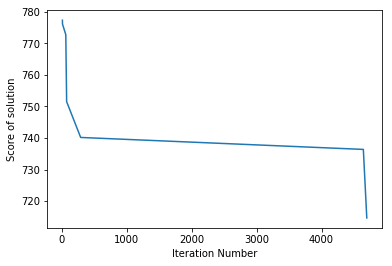

In [202]:
print('numIter:',numIter)
print('destroyN:',destroyN)
print('destroyB:',destroyB)
print('repairN',repairN)
print('repairB',repairB)
print('destroyI:',destroyI)
print('repairI:',repairI)
# scores.sort(reverse=True)
plt.plot([x[0] for x in scores],[x[1] for x in scores])
plt.ylabel('Score of solution')
plt.xlabel('Iteration Number')
# sortedScore = sorted(scores,reverse=True)
# plt.plot(sortedScore)
# plt.ylabel('Score of solution')
# plt.xlabel('Iteration Number')

In [203]:
bestSol

{0: [{'taskIndex': 888,
   'taskId': 998,
   'taskType': 'UT',
   'source': 18,
   'dest': 0,
   'mhTime': 0,
   'S': 0.0,
   'D': 30.0,
   'B': 100.0},
  {'taskIndex': 0,
   'taskId': 0,
   'taskType': 'TO',
   'source': 0,
   'dest': 10,
   'mhTime': 10,
   'ept': 30,
   'ldt': 90,
   'S': 30.0,
   'D': 53.407430106666666,
   'B': 96.53333333333333},
  {'taskIndex': 888,
   'taskId': 998,
   'taskType': 'UT',
   'source': 10,
   'dest': 1,
   'mhTime': 10,
   'S': 53.407430106666666,
   'D': 76.14819354666663,
   'B': 89.82961828},
  {'taskIndex': 1,
   'taskId': 1,
   'taskType': 'TO',
   'source': 1,
   'dest': 6,
   'mhTime': 10,
   'ept': 60,
   'ldt': 90,
   'S': 76.14819354666663,
   'D': 96.68152687999994,
   'B': 83.45923656000001},
  {'taskIndex': 888,
   'taskId': 998,
   'taskType': 'UT',
   'source': 6,
   'dest': 4,
   'mhTime': 10,
   'S': 96.68152687999994,
   'D': 110.85886021333323,
   'B': 78.19256989333334},
  {'taskIndex': 2,
   'taskId': 3,
   'taskType': 'TO',
 

In [204]:
scores

[(8, 777.2693576143299),
 (9, 776.0755097519966),
 (60, 772.6937434923302),
 (73, 751.4958956299969),
 (289, 740.1618956299969),
 (4644, 736.3733576143303),
 (4697, 714.6837434923303)]